In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
import torch

path = '../trained_models/ribbon_061723/fixed_antenna/'

#flatten array

num_pts = 5000

n = 1000*num_pts
sub_n = num_pts*100

all_dat = np.zeros((n,7))

for i in range(0,10):
    
    dat = np.load(path+str(i)+"_data_arr.npy")
    sub_dat = np.zeros((sub_n, 7))
    
    for j in range(0,100):
        
        sub_dat[j*num_pts:(j+1)*num_pts] = dat[...,j]
        
    all_dat[i*sub_n:(i+1)*sub_n] = sub_dat


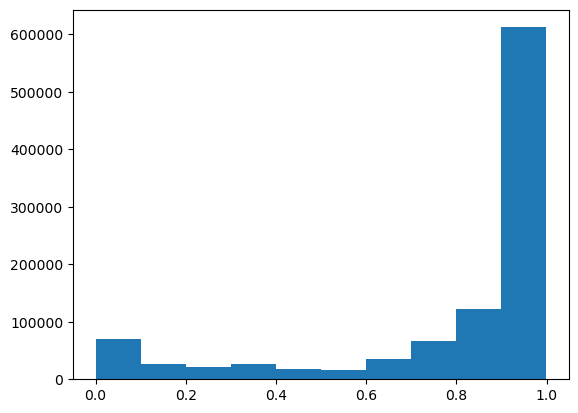

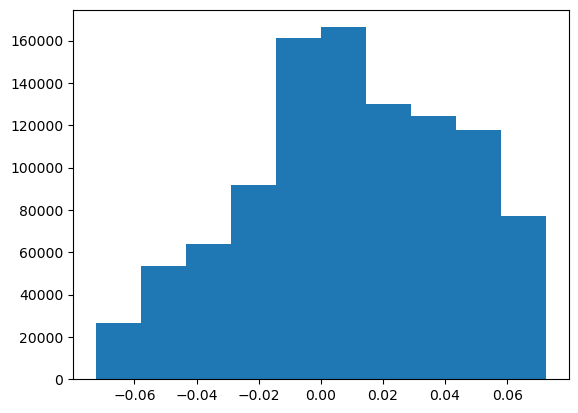

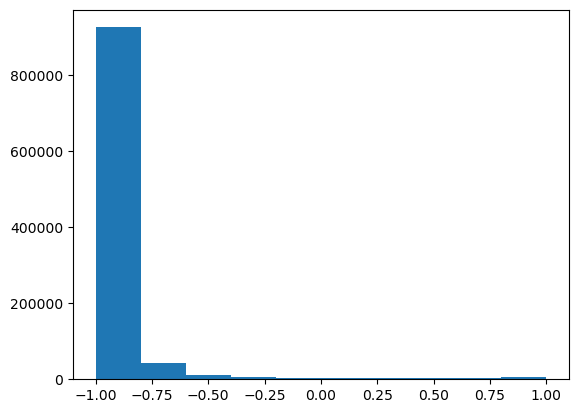

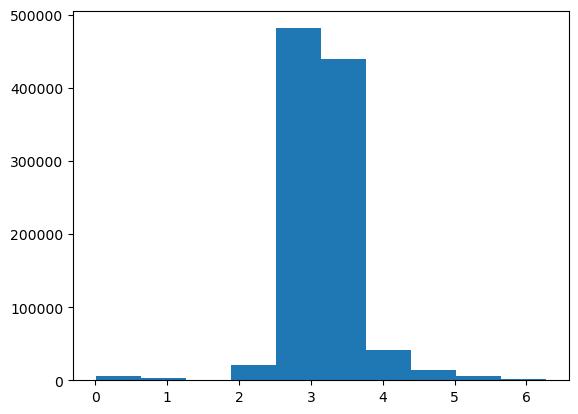

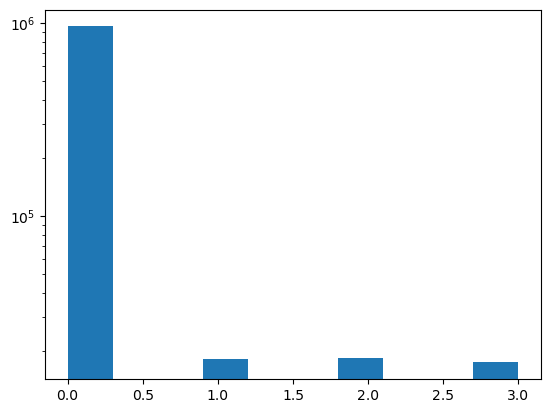

In [2]:
"""
plt.hist(all_dat[:,0])
plt.show()


plt.hist(all_dat[:,1])
plt.show()

plt.hist(all_dat[:,2])
plt.show()


plt.hist(all_dat[:,3])
plt.show()


plt.hist(all_dat[:,4])
plt.yscale('log')
plt.show()
"""

In [2]:
#let's first remove nans

nan_inds = np.isnan(np.sum(all_dat, axis =1))
not_nan_inds = np.logical_not(nan_inds)

all_dat = all_dat[not_nan_inds, :]

print(np.shape(all_dat))

relevant_dat = all_dat[:,0:4]
#theta = relevant_dat[:,3]
cos_theta = relevant_dat[:,2]
#sin_theta = np.sin(theta)
#cos_theta = np.cos(theta)

relevant_dat[:,3] = np.sin(relevant_dat[:,3])

print(np.shape(relevant_dat))
#print(np.shape(sin_theta))

#print(sin_theta[0])

#sin_theta = np.reshape(sin_theta, (sin_theta.shape[0], 1))

#print(sin_theta[0])

#relevant_dat[:,3] = cos_theta
#relevant_dat = np.hstack((relevant_dat, sin_theta))

labels = all_dat[:,4]

(1030073, 7)
(1030073, 4)


In [3]:
num_samples = len(labels)
num_sense = np.shape(relevant_dat)[1]
big_sense_data = np.zeros((num_samples, num_sense + 10))

big_sense_data[:,0:num_sense] = relevant_dat

count = 0

label_list = ['inten', 'grad', 'cos_th', 'sin_th']

for i in range(0,num_sense):
    
    j = 0
    
    while j <= i:
        
        big_sense_data[:,num_sense+count] = relevant_dat[:,i]*relevant_dat[:,j]
        
        new_str = label_list[i]+"*"+label_list[j]
        
        label_list.append(new_str)
        
        print(count, new_str)
        
        j+=1
        count+=1


0 inten*inten
1 grad*inten
2 grad*grad
3 cos_th*inten
4 cos_th*grad
5 cos_th*cos_th
6 sin_th*inten
7 sin_th*grad
8 sin_th*cos_th
9 sin_th*sin_th


In [4]:
maxes = np.max(np.abs(big_sense_data), axis = 0)
big_sense_data = big_sense_data/maxes[None,:]

In [5]:
import torchvision
from torch.utils.data import Dataset, DataLoader

rand_gen = np.random.RandomState(0)

total_inds = len(labels)

inds = np.arange(total_inds)
train_inds = rand_gen.choice(inds, replace = False, size = int(0.8*total_inds))
test_inds = np.setdiff1d(inds, train_inds)


batch_size = 5000

#no_sthmot_sense_data = np.delete(sense_data, 47, axis=1)

class train_PlumeDataset(Dataset):
    
    def __init__(self, data, labels, inds):
        
        self.x = torch.from_numpy(data[inds]).float()
        self.y = torch.from_numpy(labels[inds]).long()
        self.n_total = np.shape(data[inds])[0]
        
    def __getitem__(self,index):
        
        return self.x[index], self.y[index]
    
    def __len__(self):
        
        return self.n_total

    
print(np.shape(relevant_dat))

train_dataset = train_PlumeDataset(data = big_sense_data, labels = labels, inds = train_inds)
test_dataset = train_PlumeDataset(data = big_sense_data, labels = labels, inds = test_inds)


#creating training batches
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle = False)

check_iter = iter(train_loader)
check = next(check_iter)

features, labels = check

print(features.size())

/Users/vrj9/anaconda3/envs/plume-env/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/vrj9/anaconda3/envs/plume-env/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: <DDABACEB-F2EA-368C-80DD-40745DFB96F8> /Users/vrj9/anaconda3/envs/plume-env/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <06C5DED4-2345-38A0-A87B-C09CD199D899> /Users/vrj9/anaconda3/envs/plume-env/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")


(1030073, 4)
torch.Size([5000, 14])


In [6]:
import torch.nn as nn
torch.manual_seed(98)

#first doing GLM

class NeuralNetGLM_Four(nn.Module):
    
    def __init__(self, input_size):
        super(NeuralNetGLM_Four, self).__init__()
        self.lin1 = nn.Linear(input_size, 1)
        self.lin2 = nn.Linear(input_size, 1)
        self.lin3 = nn.Linear(input_size, 1)
        self.lin4 = nn.Linear(input_size, 1)
        
        self.nl = nn.Sigmoid()
        
    def forward(self, x):
        
        f1 = self.lin1(x)
        f2 = self.lin2(x)
        f3 = self.lin3(x)
        f4 = self.lin4(x)
        
        #glm1 = self.nl(f1)
        #glm2 = self.nl(f2)
        #glm3 = self.nl(f3)
        #glm4 = self.nl(f4)
        
        out = torch.cat((f1, f2, f3, f4), dim = 1)
        
        return out


GLM = NeuralNetGLM_Four(input_size = 14)


In [7]:
learning_rate = 0.001
labels = all_dat[:,4]

#get weights

num_samples = np.shape(relevant_dat)[0]
prop_0 = np.mean(labels==0)
prop_1 = np.mean(labels==1)
prop_2 = np.mean(labels==2)
prop_3 = np.mean(labels==3)

prop_arr = np.array([prop_0, prop_1, prop_2, prop_3])
weights = 0.25/prop_arr
weights = torch.from_numpy(weights).float()

criterion = nn.CrossEntropyLoss(weight = weights)
optimizer = torch.optim.Adam(GLM.parameters(), lr=learning_rate)

0
1.427356481552124
2
1.0531290769577026
4
0.9710437655448914
6
0.9313734769821167
8
0.8654281497001648
10
0.743162214756012
12
0.8748876452445984
14
0.8179858922958374
16
0.7981643676757812
18
0.8162574768066406
20
0.7574008703231812
22
0.778580367565155
24
0.7395502328872681
26
0.7102516889572144
28
0.6942543387413025
30
0.7962319254875183
32
0.7187675833702087
34
0.7857009172439575
36
0.7605352997779846
38
0.7988508343696594
40
0.712826132774353
42
0.7278739213943481
44
0.7762503027915955
46
0.6976586580276489
48
0.6699709296226501
50
0.7490674257278442
52
0.6508323550224304
54
0.7427825927734375
56
0.7091190218925476
58
0.7078077793121338
60
0.8186004161834717
62
0.8282544612884521
64
0.7680193185806274
66
0.7150794863700867
68
0.7259821891784668
70
0.6492534875869751
72
0.655489444732666
74
0.7285469174385071
76
0.7569643259048462
78
0.7856979966163635
80
0.7294753789901733
82
0.6920328736305237
84
0.7552192807197571
86
0.6876384615898132
88
0.7627023458480835
90
0.694435596466064

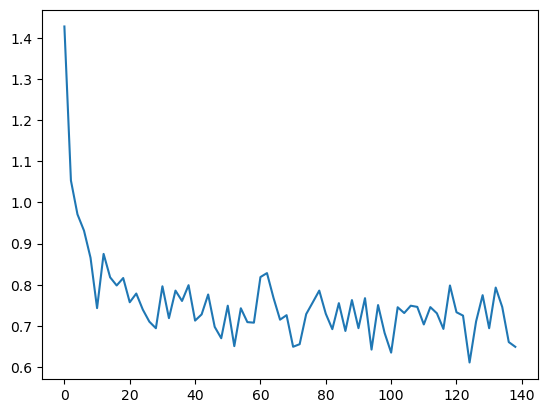

In [8]:
num_epochs = 140
loss_array = np.zeros(int(num_epochs/2))

for epoch in range(num_epochs):
    
    for i, (features, labels) in enumerate(train_loader):
        
        #print(features.size())
        #print(labels.size())
        
        outputs = GLM(features)
        
        #print(outputs.size())
        
        #assert(False)
        
        loss = criterion(outputs, labels)
        
        if i == 0 and epoch %2 ==0:
        
            print(epoch)
            ind = int(epoch/2)
            loss_array[ind] = loss.item()
            print(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        
epoch_labels = 2*np.arange(0,len(loss_array))      
plt.plot(epoch_labels, loss_array)
plt.show()


(1, 14)


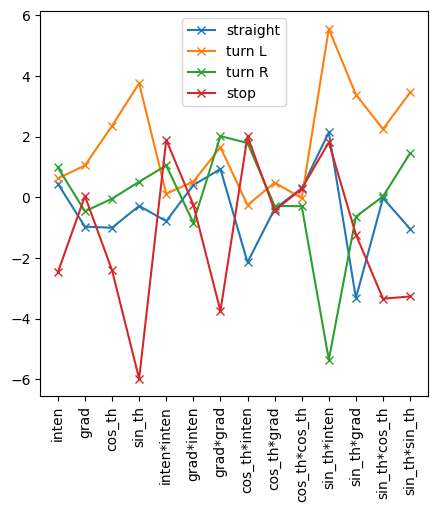

In [9]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)

for name, param in GLM.named_parameters():
    
    if param.requires_grad and name == 'lin1.weight':
        
        #print('in 1')
        
        filt_1 = param.data.numpy()
        print(np.shape(filt_1))
        #print(filt_1.squeeze())
        #ax.plot(filt_1.squeeze(), label = 'filt for 60mm/s')


    elif param.requires_grad and name == 'lin2.weight':
        
        #print('in 2')
        filt_2 = param.data.numpy()
    #    print(np.shape(filt_2))
    #    plt.plot(filt_2.squeeze(), label = 'filt for 90mm/s')

        

    elif param.requires_grad and name == 'lin3.weight':
    
    #    #print('in 2')
        filt_3 = param.data.numpy()
    #    print(np.shape(filt_3))
    #    plt.plot(filt_3.squeeze(), label = 'filt for 120mm/s')



    elif param.requires_grad and name == 'lin4.weight':
        
        #print('in 2')
        filt_4 = param.data.numpy()
        #print(np.shape(filt_3))
        #ax.plot(filt_4.squeeze(), label = 'filt for 150mm/s')
        
ax.plot(filt_1.squeeze(), 'x-', label ='straight')
ax.plot(filt_2.squeeze(), 'x-', label = 'turn L')
ax.plot(filt_3.squeeze(), 'x-', label = 'turn R')
ax.plot(filt_4.squeeze(), 'x-', label = 'stop')
plt.legend()
ax.set_xticks(np.arange(0,14))
#plt.tight_layout()
ax.set_xticklabels(label_list, rotation = 90)
plt.show()

In [10]:
conf_matrix = np.zeros((4,4))

with torch.no_grad():
    
    for features, labels in test_loader:
        
        outputs = GLM(features)
        _, output_labels = torch.max(outputs.data, 1)
        
        for i in range(0,len(output_labels)):
            
            corr = labels[i]
            pred = output_labels[i]
            
            conf_matrix[corr, pred] = conf_matrix[corr, pred]+1
            
conf_sum = np.sum(conf_matrix, axis = 1)


In [11]:
conf_sum = np.array([conf_sum])
print(np.shape(conf_sum))

conf_sum_array = np.tile(conf_sum.transpose(), (1,4))

print(conf_sum_array)


print(np.shape(conf_sum_array))

print(conf_matrix/conf_sum_array)

(1, 4)
[[191751. 191751. 191751. 191751.]
 [  2896.   2896.   2896.   2896.]
 [  2378.   2378.   2378.   2378.]
 [  8990.   8990.   8990.   8990.]]
(4, 4)
[[0.73674192 0.07241162 0.11040881 0.08043765]
 [0.21236188 0.6691989  0.02969613 0.08874309]
 [0.16232128 0.058873   0.61396131 0.16484441]
 [0.03681869 0.01268076 0.00522803 0.94527253]]
